# Logistic Regression Exoplanet Vetter

## Imports and directories

In [2]:
import sys, os
import numpy as np
import pandas as pd # to read CSV
from sklearn import model_selection, preprocessing # for multivariable linear regression
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn.metrics as skm
import h5py
import gc
import pickle
import time
for obj in gc.get_objects():   # Browse through ALL objects
    if isinstance(obj, h5py.File):   # Just HDF5 files
        try:
            obj.close()
        except:
            pass # Was already closed

sectors = ["sector-{}".format(i) for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21]]

# Manually point to TICS folder which contains labels.tsv
TICS_dropbox = "/Users/hblim/Dropbox (MIT)/qlp-data/TICS"

# Manually point to TICS folder which has preprocessed lightcurves
TICS_drive   = "/Volumes/halston_lim/School_Documents/SP_2019-2020/6.862/TICS/updatedH5"

## Option 1: Import Old Data and Count existing files

In [10]:
  # Features:
  #   [0] astronet score
  #   [1] depth best ap - 1
  #   [2] depth best ap (global)
  #   [3] depth best ap + 1 or best ap
  #   [4] error best ap - 1
  #   [5] error best ap (global)
  #   [6] error best ap + 1
  # 
  #   [7] depth best ap - 1
  #   [8] depth best ap (local)
  #   [9] depth best ap + 1 or best ap
  #   [10] error best ap - 1
  #   [11] error best ap (local)
  #   [12] error best ap + 1
  # 
  #   [13] depth even
  #   [14] depth odd
  #   [15] error even
  #   [16] error odd

  #   [17] depth secondary
  #   [18] error seconday

  #   [19] label

In [3]:
# get all files that have lightcurves
filelist = []
for i,sector in enumerate(sectors):
    filelist += os.listdir(os.path.join(TICS_drive,sector,"preprocessed"))
filelist = list(set(filelist))
print(len(filelist),"lightcurve files")

145415 lightcurve files


In [5]:
labels_tsv = np.genfromtxt(os.path.join(TICS_dropbox,"labels.tsv"),skip_header = 3,usecols=(0),dtype='i8')

# get files from 
filelist = open(os.path.join(TICS_drive,"filelist.txt"),'r').readlines()
filelist = set([i.strip() for i in filelist])

labels_str = set([str(labels_tsv[i]) + '.h5' for i in range(len(labels_tsv))])
print("total files: ", len(filelist))
print("total planets: ", len(filelist.intersection(labels_str)))
print("total missing: ", len(labels_str - filelist.intersection(labels_str)))

missing = list(labels_str - filelist.intersection(labels_str))
fout = open(os.path.join(TICS_drive,"missing.txt"),'w')
for m in missing:
    fout.write(m + '\n')
fout.close()

total files:  134628
total planets:  800
total missing:  893


In [6]:
# Global folder paths
datapath  = "/Volumes/halston_lim/School_Documents/SP_2019-2020/6.862/TICS/"

# Manually include which sectors names to scan
sectors = ["sector-{}".format(i) for i in \
           [1,2,3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21]]

data = np.zeros((0,20))
for i in range(len(sectors)):
    datatemp = np.load(os.path.join(datapath,sectors[i],'lcFeatures.npy'))
    data = np.append(data,datatemp,axis = 0)

In [9]:
n_planet = np.sum(data[:,-1] == 1)
n_nonplanet = np.sum(data[:,-1] == 0)
n_planet,n_nonplanet,n_planet / n_nonplanet

fdata = data[:,[0,1,2,3,7,8,9,13,14,17,19]]
X = fdata[:,0:-1]
y = fdata[:,-1] * 2 - 1

NameError: name 'data' is not defined

## Options 2: Import New Data

In [12]:
def read_pickle(filepath):
    
    assert os.path.exists(filepath)
    ft = open(filepath,'rb')
    f = pickle.load(ft)    
    
    nfiles = len(f)
    
    # Views
    localviews = np.zeros((nfiles,3,61))
    globalviews = np.zeros((nfiles,3,201))
    
    # Scalar features
    std_depths = np.zeros((nfiles,2))
    true_depths = np.zeros((nfiles,6))
    astronet_score = np.zeros((nfiles,1))
    stellar_radii = np.zeros((nfiles,1))

    # Labels
    labels = np.zeros((nfiles,))

    
    for i,file in enumerate(f):
        
        stdcut = (np.std(file['LocalDepths']) < 1) and (np.std(file['GlobalDepths']) < 1)
        non_zero_depths = ((np.sum(file['LocalDepths'] == 0) + np.sum(file['GlobalDepths'] == 0)) == 0)
        no_nans = np.sum(np.isnan(file['LocalView'])) + np.sum(np.isnan(file['GlobalView'])) == 0
        
        if no_nans and non_zero_depths and stdcut:
        
            localviews[i] = file['LocalView']
            globalviews[i] = file['GlobalView']
            labels[i] = file['label']

            astronet_score[i] = np.array([file['AstroNetScore']])
            std_depths[i] = np.array([np.std(file['LocalDepths']),np.std(file['GlobalDepths'])])
            true_depths[i] = np.hstack([file['LocalDepths'],file['GlobalDepths']])    
            stellar_radii[i] = np.array([file['StellarParams']['rad']])
    ft.close()
    return localviews, globalviews, std_depths, true_depths, astronet_score, stellar_radii, labels

In [13]:
verbose = 1
pickle_dir = "/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/"

std_depths = np.zeros((0,2))
true_depths = np.zeros((0,6))
astronets = np.zeros((0,1))
stellar_radii = np.zeros((0,1))

all_localviews = np.zeros((0,3,61))
all_globalviews = np.zeros((0,3,201))
all_labels = np.zeros((0,),dtype=int)

# append with data from each sector
for sector in range(1,22):
    
    filepath = pickle_dir + 'sector-{}.pickle'.format(sector)
    print(filepath)
    localviews, globalviews, std_depth, true_depth, astronet_score, stellar_rad, labels = read_pickle(filepath)
    
    std_depths = np.append(std_depths, std_depth,axis=0)
    true_depths = np.append(true_depths,true_depth,axis=0)
    astronets = np.append(astronets, astronet_score, axis = 0)
    stellar_radii = np.append(stellar_radii, stellar_rad , axis = 0)
    
    
    all_localviews = np.append(all_localviews, localviews,axis=0)
    all_globalviews = np.append(all_globalviews, globalviews,axis=0)
    all_labels = np.append(all_labels,labels)

if verbose:
    print("X_global.shape = ", all_globalviews.shape)
    print("X_local.shape  = ", all_localviews.shape)
    print("X_depths.shape = ", true_depths.shape)
    print("y.shape        = ", all_labels.shape)

/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-1.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-2.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-3.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-4.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-5.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-6.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-7.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-8.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-9.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-10.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-11.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-12.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-13.pickle
/Users/hblim/Dropbox (MIT)/qlp-data/2020_05_updatedLC/sector-14.pickle
/Users/hblim/Dr

In [14]:
verbose = 1
ntotal = len(all_labels)
X = np.zeros((ntotal,0))
# X = np.append(X, all_localviews.reshape((ntotal,3*61)),axis=1)
# X = np.append(X, all_globalviews.reshape((ntotal,3*201)),axis=1)
X = np.append(X, std_depths.reshape((ntotal,2)),axis=1)
X = np.append(X, astronets.reshape((ntotal,1)),axis=1)
# X = np.append(X, true_depths.reshape((ntotal,6)),axis=1)
X = np.append(X, all_labels.reshape((ntotal,1)),axis=1)

# downsample majority class
PCs = all_labels == 1
nonPCs = all_labels == 0
X_PC = X[PCs]
X_nPC = X[nonPCs]

np.random.shuffle(X_nPC)
# X_nPC = X_nPC[0:int(np.sum(nonPCs) / 10)]
# X_nPC = X_nPC[0:int(np.sum(PCs)) ]

Xfil = np.vstack([X_PC,X_nPC])
np.random.shuffle(Xfil)


X = Xfil[:,:-1]
y = Xfil[:,-1].astype(int)
# if verbose: print("X.shape = ", X.shape)

## Use all data columns

Data and labels $X$ and $y$ should be defined

In [15]:
kfold_score = [] # RMSE per case
kfold_predict = [] # predict class

n_cases = (X.shape)[0]
nfolds = 5
nthreshs = 20
kfold_predict = []
kfold_classifies = np.zeros((nfolds,5),dtype='i8')
kfold_probabilities = np.zeros((nfolds,5,nthreshs),dtype='i8')

precision_recall = []

kfold = model_selection.StratifiedKFold(n_splits = nfolds,shuffle=True)
i = 0
t0 = time.time()
for train_index, test_index in kfold.split(X,y):

    t0 = time.time()
    
    # split into test, training
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # scale training data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_sc = scaler.transform(X_train)
    
    # regress
    reg = lm.LogisticRegression( \
                                penalty='l2',
                                fit_intercept=True,
                                C = 1.0,
                                random_state=420,
                                solver='sag',
                                tol = 1e-4,
                                class_weight = 'balanced',
                                max_iter = 2500,
                                multi_class='ovr',
                                warm_start=True
                               )
    reg.fit(X_train_sc,y_train)

    # scale test data and predict
    X_test_sc = scaler.transform(X_test)
    prediction = reg.predict(X_test_sc)
    probabilities = reg.predict_proba(X_test_sc)
    kfold_predict.append(prediction)
    
    precision_recall.append(skm.precision_recall_curve(np.array(y_test),probabilities[:,1],pos_label=1))

    # evaluate fold
    yt = np.array(y_test)
    right = (yt - prediction == 0)
    planet = (yt == 1)
    
    n_total = len(yt)
    n_true = np.sum(right)
    n_true_planet = np.sum(np.logical_and(right,planet))
    n_falsepos = np.sum(np.logical_and(~right,~planet))
    n_falseneg = np.sum(np.logical_and(~right,planet))

    kfold_classifies[i][0] = n_total
    kfold_classifies[i][1] = np.sum(planet)
    kfold_classifies[i][2] = n_true_planet
    kfold_classifies[i][3] = n_falsepos
    kfold_classifies[i][4] = n_falseneg
    
    
    print("Fold #{}: {:.4f}".format(i,time.time() -t0))
    i += 1

/Users/hblim/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fold #0: 74.4588


/Users/hblim/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fold #1: 81.7326


/Users/hblim/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fold #2: 79.3845
Fold #3: 1.8791
Fold #4: 88.5656


/Users/hblim/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


Text(0.5, 0, 'Recall')

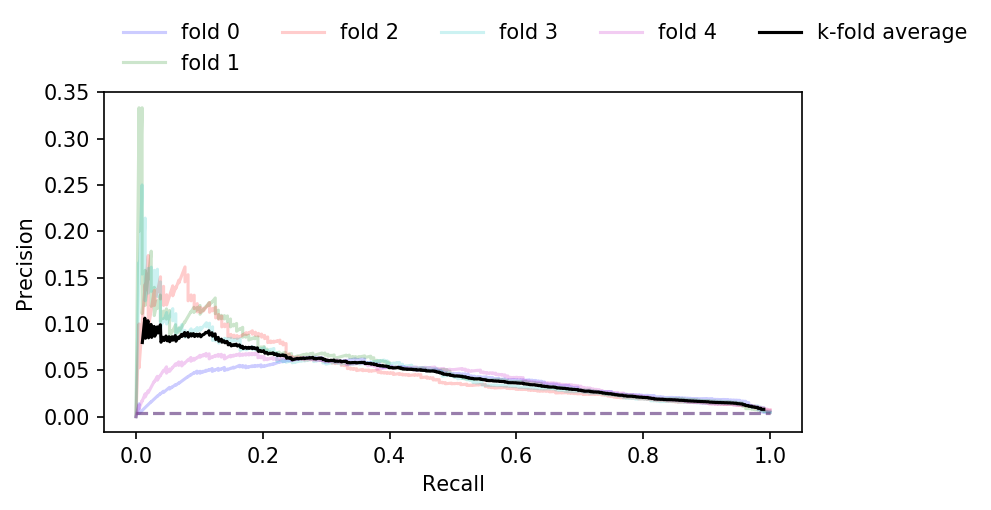

In [16]:
plt.figure(figsize = (6,3),dpi = 150)

xp = np.linspace(0.01,.99,1000)
yp = np.zeros((nfolds,len(xp)))

colors = ['b','g','r','c','m']

for i in range(nfolds):
    noskill = kfold_classifies[i,1] / kfold_classifies[i,0] 
    plt.plot(precision_recall[i][1][:-1],precision_recall[i][0][:-1],color=colors[i],alpha=0.2,label="fold {}".format(i))
    plt.plot([0,1],[noskill,noskill],color=colors[i],linestyle='--',alpha=0.2)
    yp[i] = np.interp(xp,precision_recall[i][1][-1:0:-1],precision_recall[i][0][-1:0:-1])
    print(yp[i].shape)

# average
plt.plot(xp,np.mean(yp,axis=0),'k-',label='k-fold average')

plt.legend(frameon=False,ncol=nfolds,bbox_to_anchor=(0,1),loc='lower left')
plt.ylabel('Precision')
plt.xlabel('Recall')